##**Skenario**

Sebuah jaringan restoran cepat saji berencana menambahkan menu baru. Namun, mereka masih ragu untuk memilih salah satu dari tiga kemungkinan kampanye pemasaran guna mempromosikan produk baru tersebut. Untuk mengetahui promosi mana yang paling berpengaruh terhadap penjualan, menu baru diperkenalkan di beberapa lokasi yang dipilih secara acak pada pasar tertentu. Setiap lokasi menggunakan strategi promosi yang berbeda, lalu penjualan mingguan produk baru tersebut dicatat selama empat minggu pertama.

##**Goals**

Mengevaluasi hasil uji A/B dan menentukan strategi pemasaran mana yang memberikan hasil penjualan terbaik.

##**Variabel yang Tersedia**

Dari dataset yang dimiliki terdapat beberapa data yang tersedia:

---

**1. MarketID:** pengidentifikasi unik untuk pasar\
**2. MarketSize:** ukuran area pasar berdasarkan penjualan\
**3. LocationID:** pengidentifikasi unik untuk lokasi toko\
**4. AgeOfStore:** usia toko dalam tahun\
**5. Promotion:** satu dari tiga promosi yang diuji\
**6. week:** satu dari empat minggu saat promosi dijalankan\
**7. SalesInThousands:** jumlah penjualan untuk LocationID, Promosi, dan minggu tertentu

##**Data Preparation and Understanding**

####**Import Library and Load Data**

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [10]:
df = pd.read_csv('WA_Marketing-Campaign.csv', header=0)
pd.set_option('display.max_column', None)

####**Data Inspection**

In [61]:
# Dataframe
df

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands,Log_Sales
0,1,Medium,1,4,3,1,33.73,3.518388
1,1,Medium,1,4,3,2,35.67,3.574310
2,1,Medium,1,4,3,3,29.03,3.368330
3,1,Medium,1,4,3,4,39.25,3.669951
4,1,Medium,2,5,2,1,27.81,3.325396
...,...,...,...,...,...,...,...,...
543,10,Large,919,2,1,4,64.34,4.164182
544,10,Large,920,14,2,1,50.20,3.916015
545,10,Large,920,14,2,2,45.75,3.823192
546,10,Large,920,14,2,3,44.29,3.790759


In [62]:
# Cek Struktur Data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
 7   Log_Sales         548 non-null    float64
dtypes: float64(2), int64(5), object(1)
memory usage: 34.4+ KB


In [63]:
# Cek Statistika Deskriptif
df.describe()

,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands,Log_Sales
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204,3.931895
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216,0.307648
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000,2.853016
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000,3.750562
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000,3.916015
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500,4.102271
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000,4.601664


In [64]:
# Cek Missing Value
df.isnull().sum()

,0
MarketID,0
MarketSize,0
LocationID,0
AgeOfStore,0
Promotion,0
week,0
SalesInThousands,0
Log_Sales,0


In [65]:
# Cek Data Duplicate
df.duplicated().sum()

np.int64(0)

In [66]:
# Cek keseimbangan observasi di setiap grup promosi
print("\nJumlah observasi per grup Promosi:")
print(df['Promotion'].value_counts())


Jumlah observasi per grup Promosi:
Promotion
3    188
2    188
1    172
Name: count, dtype: int64


In [67]:
# Cek variabel lainnya
print("Jumlah Lokasi:", df['LocationID'].nunique())
print("Ukuran Pasar:", df['MarketSize'].unique())
print("Rentang Usia Toko:", df['AgeOfStore'].min(), "-", df['AgeOfStore'].max())
print("Minggu ke:", df['week'].unique())

Jumlah Lokasi: 137
Ukuran Pasar: ['Medium' 'Small' 'Large']
Rentang Usia Toko: 1 - 28
Minggu ke: [1 2 3 4]


##**Visualisasi Distribusi Data**

Untuk memahami karakteristik data penjualan pada masing-masing jenis promosi, dilakukan beberapa visualisasi.

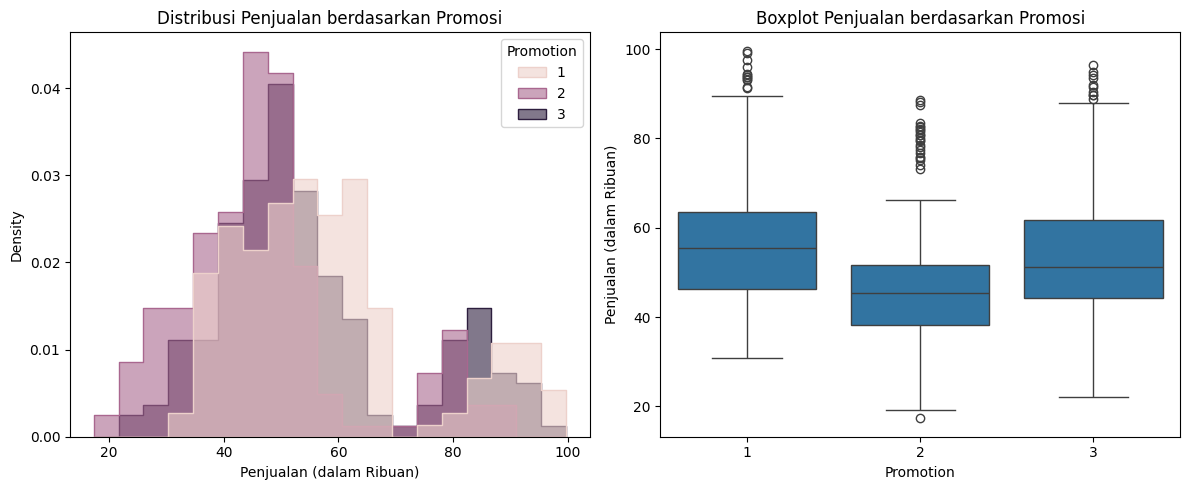

In [68]:
# Visualisasi distribusi Penjualan berdasarkan grup Promosi
plt.figure(figsize=(12, 5))

# Histogram dengan KDE
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='SalesInThousands', hue='Promotion', element='step', stat='density', common_norm=False, alpha=0.6)
plt.title('Distribusi Penjualan berdasarkan Promosi')
plt.xlabel('Penjualan (dalam Ribuan)')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Promotion', y='SalesInThousands')
plt.title('Boxplot Penjualan berdasarkan Promosi')
plt.ylabel('Penjualan (dalam Ribuan)')

plt.tight_layout()
plt.show()

Berdasarakan histogram distribusi penjualan, ketiga jenis promosi terlihat heavy-tailed, di mana sebagian besar data terkonsentrasi pada nilai penjualan yang relatif rendah, sementara terdapat sejumlah outlier pada nilai penjualan yang tinggi. Pola ini menunjukkan bahwa setiap promosi memiliki distribusi yang sedikit berbeda satu sama lain. Kondisi ini juga mengonfirmasi perlunya melakukan transformasi untuk mengatasi ketidaknormalan data, sekaligus menyoroti adanya perbedaan variansi antar kelompok.

Lebih lanjut, outliers tampak jelas berada di atas whisker sebagai titik-titik terpisah dari box, sementara median yang ditunjukkan oleh garis tengah box berbeda antar kelompok promosi. Selain itu, tinggi box (IQR) memperlihatkan variasi sebaran data di dalam masing-masing grup. Hal ini mengindikasikan bahwa efektivitas promosi tidak hanya berbeda dari sisi nilai tengah penjualan, tetapi juga dari tingkat konsistensinya.

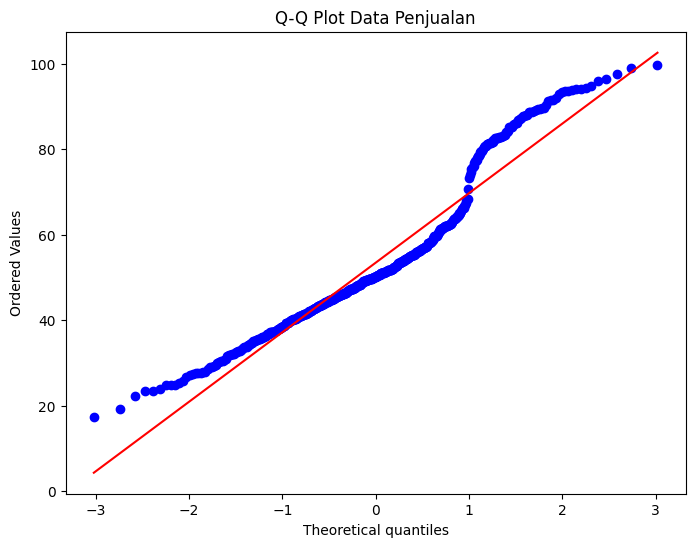

In [69]:
# Membuat Q-Q plot untuk memeriksa normalitas data
plt.figure(figsize=(8, 6))
stats.probplot(df['SalesInThousands'], dist="norm", plot=plt)
plt.title('Q-Q Plot Data Penjualan')
plt.show()

Q-Q plot data penjualan menunjukkan bahwa titik-titik data tidak mengikuti garis diagonal secara konsisten, terutama pada bagian ekor bawah dan atas distribusi. Pola ini menandakan bahwa data penjualan menyimpang dari distribusi normal, dengan adanya ekor berat (heavy tails) dan deviasi di area ekstrem. Hal ini menguatkan kebutuhan untuk melakukan transformasi agar asumsi normalitas lebih mendekati terpenuhi sebelum dilakukan analisis lanjutan.


##**Transformasi Data**

Transformasi data dilakukan untuk memperbaiki distribusi yang tidak normal dan mengurangi pengaruh outlier sehingga analisis statistik menjadi lebih valid. Pada kasus ini, transformasi log dipilih karena data penjualan menunjukkan pola heavy-tailed dengan deviasi yang cukup besar pada ekor distribusi.

In [70]:
# Menerapkan transformasi log untuk menangani heavy tails
df['Log_Sales'] = np.log(df['SalesInThousands'])

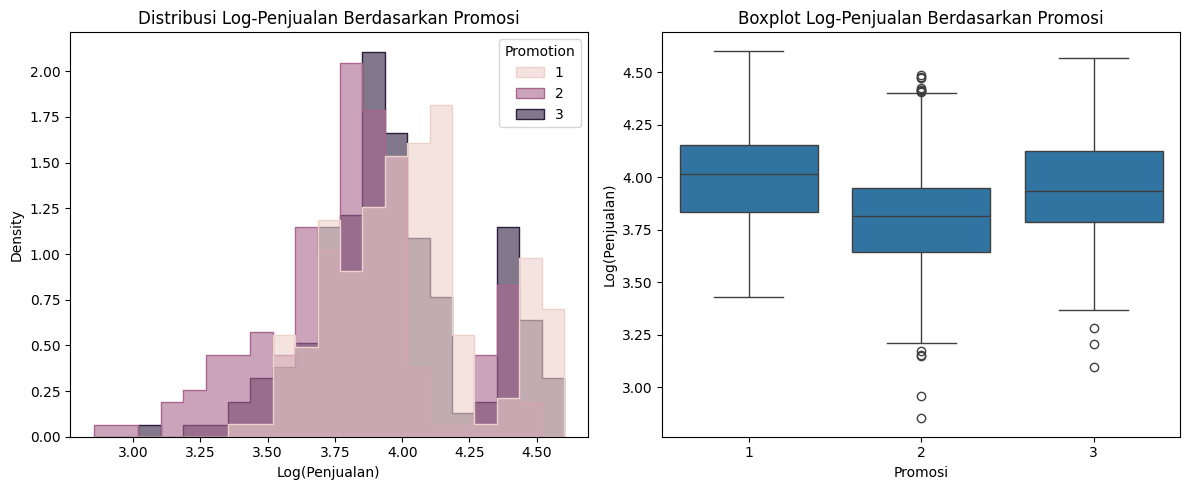

In [71]:
# Cek distribusi setelah transformasi
plt.figure(figsize=(12, 5))

# Histogram dengan KDE
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Log_Sales', hue='Promotion', element='step', stat='density', common_norm=False, alpha=0.6)
plt.title('Distribusi Log-Penjualan Berdasarkan Promosi')
plt.xlabel('Log(Penjualan)')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Promotion', y='Log_Sales')
plt.title('Boxplot Log-Penjualan Berdasarkan Promosi')
plt.ylabel('Log(Penjualan)')
plt.xlabel('Promosi')

plt.tight_layout()
plt.show()

Setelah dilakukan transformasi log, distribusi penjualan untuk ketiga jenis promosi terlihat lebih simetris dan tidak lagi terlalu heavy-tailed. Pola distribusi menunjukkan konsentrasi data yang lebih merata di sekitar nilai tengah, sehingga perbedaan antar promosi dapat diamati dengan lebih jelas. Kondisi ini menandakan bahwa transformasi berhasil mengurangi deviasi ekstrem pada ekor distribusi sekaligus membuat bentuk distribusi lebih mendekati normal.


Pada boxplot, jumlah dan tingkat ekstremitas outlier berkurang cukup signifikan, sementara median antar promosi menjadi lebih stabil. Tinggi box (IQR) juga tampak lebih seimbang antar kelompok, yang berarti variansi penjualan antar promosi lebih homogen dibandingkan sebelum transformasi. Dengan demikian, hasil transformasi log tidak hanya memperbaiki distribusi data, tetapi juga meningkatkan validitas asumsi untuk analisis statistik selanjutnya.

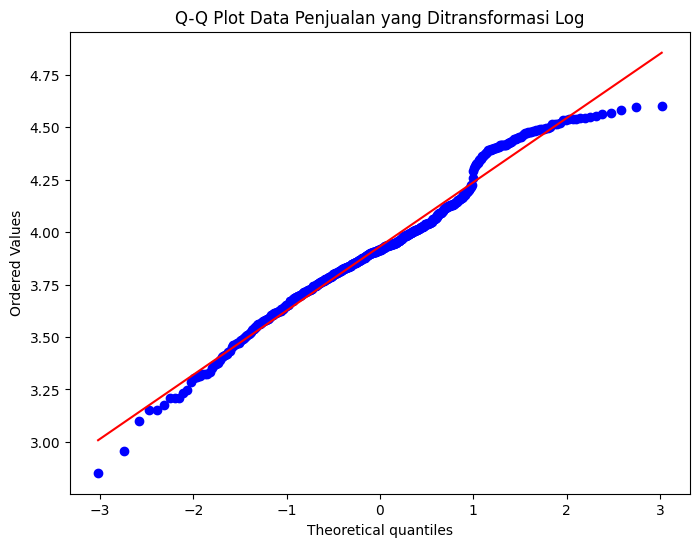

In [72]:
# Cek normalitas data setelah transformasi
plt.figure(figsize=(8, 6))
stats.probplot(df['Log_Sales'], dist="norm", plot=plt)
plt.title('Q-Q Plot Data Penjualan yang Ditransformasi Log')
plt.show()

Q-Q plot setelah transformasi log memperlihatkan bahwa sebagian besar titik mengikuti garis diagonal merah, yang menunjukkan distribusi data mendekati normal. Penyimpangan hanya terlihat pada bagian ekor, sehingga secara keseluruhan asumsi normalitas cukup terpenuhi untuk analisis statistik parametrik.

Selanjutnya, untuk mengetahui apakah terdapat perbedaan rata-rata penjualan yang signifikan antar jenis promosi, dilakukan analisis statistik menggunakan uji ANOVA.

##**Analisis Statistik: ANOVA**

Analisis ANOVA digunakan untuk menguji apakah terdapat perbedaan yang signifikan di antara beberapa kelompok promosi. Metode ini membantu menentukan apakah variasi penjualan disebabkan oleh jenis promosi yang berbeda atau hanya akibat variasi acak.

Hipotesis:
- H0: Semua promosi memiliki pengaruh yang sama terhadap penjualan.
- H1: Minimal satu promosi berbeda pengaruhnya terhadap penjualan.

In [47]:
# ANOVA pada data yang sudah ditransformasi
model = ols('Log_Sales ~ C(Promotion)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq     df          F        PR(>F)
C(Promotion)   4.598830    2.0  26.565419  9.796796e-12
Residual      47.173401  545.0        NaN           NaN


Nilai p-value yang sangat kecil (<0,05) menunjukkan bahwa minimal ada satu jenis promosi yang berpengaruh signifikan terhadap penjualan. Artinya, tidak semua promosi sama efeknya.

In [81]:
# Simpan nilai p-value
p_value = anova_table['PR(>F)'][0]
p_value

/tmp/ipython-input-3126074182.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]


np.float64(9.796796465206182e-12)

In [80]:
# Sebagai validasi tambahan, lakukan uji Kruskal-Wallis (non-parametrik)
from scipy.stats import kruskal

kw_stat, kw_pvalue = kruskal(
    df[df['Promotion'] == 1]['SalesInThousands'],
    df[df['Promotion'] == 2]['SalesInThousands'],
    df[df['Promotion'] == 3]['SalesInThousands'])

print(f"Statistic: {kw_stat:.4f}, p-value: {kw_pvalue:.6f}")

Statistic: 53.2948, p-value: 0.000000


Karena masih ada sedikit penyimpangan pada bagian ekor data setelah transformasi log, yang mungkin dapat mempengaruhi keakuratan ANOVA, maka untuk memastikan robustnes hasil dan tidak bergantung pada asumsi distribusi, dilakukan juga uji non-parametrik Kruskal-Wallis sebagai pelengkap. Sebagai uji non-parametrik, Kruskal-Wallis tidak memerlukan asumsi normalitas dan bekerja dengan meranking data untuk menguji perbedaan median antar grup. Hasil p-value 0.000000 mengonfirmasi bahwa setidaknya satu promosi memiliki performa penjualan yang secara statistik berbeda signifikan.

Langkah selanjutnya adalah melakukan uji post-hoc (misal Tukey HSD) untuk menentukan promosi mana yang berbeda secara signifikan satu sama lain.

##**Uji Post-Hoc: Tukey HSD**

Uji Tukey HSD dilakukan untuk mengetahui pasangan promosi mana yang berbeda secara spesifik. Analisis ini tidak hanya menampilkan hasil dalam bentuk tabel, tetapi juga divisualisasikan dengan grafik untuk memperjelas perbedaan antar promosi. Hasil ini akan menjadi dasar dalam memilih promosi yang paling efektif.

Rincian analisis:

* Perbandingan berpasangan: Group1 vs Group2, Group1 vs Group3, Group2 vs Group3.
* Visualisasi: Grafik perbedaan dan signifikansi antar promosi.
* Keputusan bisnis: Menentukan promosi yang memberikan hasil terbaik.


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2  -0.2156    0.0 -0.2886 -0.1427   True
     1      3  -0.0541 0.1899 -0.1271  0.0188  False
     2      3   0.1615    0.0  0.0902  0.2328   True
----------------------------------------------------


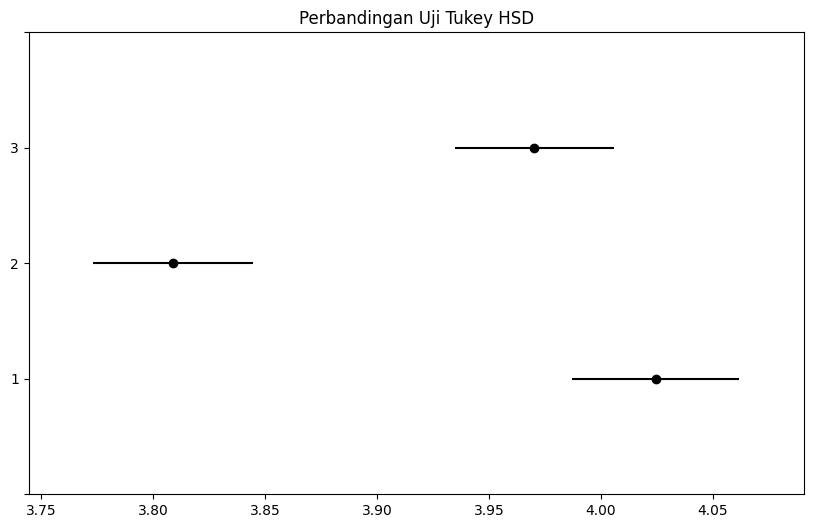

In [ ]:
# Lakukan uji Tukey HSD untuk perbandingan berpasangan
if anova_table['PR(>F)'].iloc[0] < 0.05:
    tukey = pairwise_tukeyhsd(endog=df['Log_Sales'], groups=df['Promotion'], alpha=0.05)
    print(tukey.summary())

    # Visualisasi hasil uji Tukey
    tukey.plot_simultaneous()
    plt.title("Perbandingan Uji Tukey HSD")
    plt.show()
else:
    print("\nTidak ditemukan perbedaan signifikan antara promosi (p > 0.05)")

Secara keseluruhan, Promosi 2 konsisten lebih rendah performanya dibanding Promosi 1 dan 3, sementara Promosi 1 dan 3 tidak berbeda signifikan sehingga keduanya dapat dianggap sama efektif.

Untuk memastikan bahwa perbedaan antar promosi benar-benar konsisten dan tidak hanya dipengaruhi oleh sampel yang ada, dilakukan validasi tambahan menggunakan metode bootstrap.


##**Validasi dengan Bootstrap**

Metode bootstrap digunakan sebagai pendekatan non-parametrik untuk memvalidasi hasil analisis sebelumnya. Teknik ini menghasilkan confidence interval untuk estimasi rata-rata penjualan, sehingga memberikan gambaran rentang nilai yang mungkin terjadi di populasi. Selain itu, bootstrap berfungsi sebagai robustness check untuk memastikan bahwa hasil yang diperoleh tidak bergantung pada asumsi distribusi tertentu. Melalui pendekatan ini, besarnya perbedaan penjualan antar promosi dapat diestimasi dalam satuan yang lebih nyata, yaitu US Dollar.

In [113]:
# Hitung mean aktual dari data asli terlebih dahulu
actual_means = df.groupby('Promotion')['SalesInThousands'].mean()

# Pendekatan Bootstrap
def bootstrap_means(data, n_bootstraps=10000):
    """Fungsi bootstrap untuk mendistribusikan sampling dari mean"""
    boot_means = []
    n = len(data)
    for _ in range(n_bootstraps):
        boot_sample = np.random.choice(data, size=n, replace=True)
        boot_means.append(np.mean(boot_sample))
    return boot_means

# Mendapatkan distribusi bootstrap untuk setiap promosi
promo_groups = df['Promotion'].unique()
boot_results = {}

for promo in sorted(promo_groups):
    promo_data = df[df['Promotion'] == promo]['SalesInThousands']
    boot_means = bootstrap_means(promo_data)
    boot_results[promo] = boot_means

# Menghitung 95% confidence interval untuk setiap promosi
print("Hasil Bootstrap (95% Confidence Intervals):")
for promo, means in boot_results.items():
    ci_low = np.percentile(means, 2.5)
    ci_high = np.percentile(means, 97.5)
    point_estimate = np.mean(means)
    print(f"Promosi {promo}: USD {point_estimate:.2f}K [{ci_low:.2f}K - {ci_high:.2f}K]")

# Menghitung perbedaan berpasangan antar promosi
print("\nPerbandingan Pasangan Bootstrap:")
comparisons = [(1, 2), (1, 3), (2, 3)]
for promo_a, promo_b in comparisons:
    diff_means = np.array(boot_results[promo_b]) - np.array(boot_results[promo_a])
    ci_low = np.percentile(diff_means, 2.5)
    ci_high = np.percentile(diff_means, 97.5)
    point_estimate = np.mean(diff_means)

    print(f"Promo {promo_b} vs Promo {promo_a}: USD {point_estimate:.2f}K [{ci_low:.2f}K - {ci_high:.2f}K]", end=" \n")


Hasil Bootstrap (95% Confidence Intervals):
Promosi 1: USD 58.10K [55.67K - 60.59K]
Promosi 2: USD 47.33K [45.18K - 49.54K]
Promosi 3: USD 55.36K [53.02K - 57.77K]

Perbandingan Pasangan Bootstrap:
Promo 2 vs Promo 1: USD -10.77K [-14.05K - -7.43K] 
Promo 3 vs Promo 1: USD -2.74K [-6.14K - 0.68K] 
Promo 3 vs Promo 2: USD 8.03K [4.78K - 11.28K] 


Hasil validasi dengan bootstrap memperkuat temuan sebelumnya. Rata-rata penjualan Promosi 1 (USD 58,10K) dan Promosi 3 (USD 55,36K) berada pada tingkat yang lebih tinggi dibandingkan Promosi 2 (USD 47,33K), dengan interval kepercayaan yang tidak saling tumpang tindih. Perbandingan pasangan menunjukkan bahwa Promosi 1 secara signifikan lebih baik daripada Promosi 2, dan Promosi 3 juga secara signifikan lebih baik daripada Promosi 2. Sementara itu, selisih antara Promosi 1 dan Promosi 3 tidak signifikan karena interval perbedaannya mencakup nol. Dengan demikian, Promosi 2 terbukti paling tidak efektif, sedangkan Promosi 1 dan 3 dapat dianggap sama kuat dalam mendorong penjualan.

##**Hasil**

In [110]:
# Hitung promosi dengan mean tertinggi
best_promo = actual_means.idxmax()
best_sales = actual_means.max()
worst_promo = actual_means.idxmin()
worst_sales = actual_means.min()

print(f"Performa Penjualan:")
for promo in [1, 2, 3]:
    mean_sales = actual_means[promo]
    print(f"• Promosi {promo}: USD {mean_sales:.2f}K")

print(f"\nPromosi Terbaik: Promosi {best_promo} (USD {best_sales:.2f}K)")
print(f"Promosi Terburuk: Promosi {worst_promo} (USD {worst_sales:.2f}K)")

# Berdasarkan signifikansi
print(f"\nPerbedaan antar promosi tidak signifikan secara statistik (p = {p_value:.4f})")
print(f"Perbedaan antara promosi terbaik dan terburuk: USD {(best_sales-worst_sales):.2f}K")

Performa Penjualan:
• Promosi 1: USD 58.10K
• Promosi 2: USD 47.33K
• Promosi 3: USD 55.36K

Promosi Terbaik: Promosi 1 (USD 58.10K)
Promosi Terburuk: Promosi 2 (USD 47.33K)

Perbedaan antar promosi tidak signifikan secara statistik (p = 0.0000)
Perbedaan antara promosi terbaik dan terburuk: USD 10.77K


Promosi 2 secara konsisten memiliki performa terendah sehingga kurang efektif dalam meningkatkan penjualan. Sebaliknya, Promosi 1 dan Promosi 3 menunjukkan performa yang lebih baik dengan hasil yang tidak berbeda signifikan. Oleh karena itu, strategi promosi sebaiknya difokuskan pada Promosi 1 atau Promosi 3, sementara Promosi 2 dapat dipertimbangkan untuk dievaluasi atau diganti dengan pendekatan lain